<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF/blob/main/UnDIP_Colab_Apex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/BehnoodRasti/UnDIP

fatal: destination path 'UnDIP' already exists and is not an empty directory.


In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  1 09:23:20 2021
@author: behnood
"""


from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from UnDIP.models import *

import torch
import torch.optim

#from skimage.measure import compare_psnr
#from skimage.measure import compare_mse
from skimage.metrics  import peak_signal_noise_ratio as compare_psnr
from skimage.metrics  import mean_squared_error as compare_mse
from UnDIP.utils.denoising_utils import *

from skimage._shared import *
from skimage.util import *
from skimage.metrics.simple_metrics import _as_floats
from skimage.metrics.simple_metrics import mean_squared_error

from UnDIP.UtilityMine import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
#%% Load image
import scipy.io
#%%
fname2  = "UnDIP/Data/Samson/Y_clean.mat"
mat2 = scipy.io.loadmat(fname2)
img_np_gt = mat2["Y_clean"]
img_np_gt = img_np_gt.transpose(2,0,1)
[p1, nr1, nc1] = img_np_gt.shape
#%%
fname3  = "UnDIP/Data/Samson/A_true.mat"
mat3 = scipy.io.loadmat(fname3)
A_true_np = mat3["A_true"]
A_true_np = A_true_np.transpose(2,0,1)
#%%
fname4  = "UnDIP/Data/Samson/E.mat"
mat4 = scipy.io.loadmat(fname4)
E_np = mat4["E"]
n_lin=50
E_Lin=np.zeros((1,n_lin))
E_Lin[0,:]=np.linspace(0.5,1.5,n_lin)
rmax=E_np.shape[1]
EE=np.zeros((p1,rmax*n_lin))

#%%
import matplotlib.pyplot as plt
npar=np.zeros((1,4))
npar[0,0]=41
npar[0,1]=129
npar[0,2]=410
npar[0,3]=600
tol1=npar.shape[1]
tol2=5
Metric=np.zeros((tol2,10,tol1))
#mse_E=np.zeros((tol1,tol2))
save_result=False
import time
from tqdm import tqdm

  0%|          | 0/5 [00:00<?, ?it/s]

20.08212051334433


CAE_AbEst(
  (conv1): Sequential(
    (0): Sequential(
      (1): Concat(
        (0): Sequential(
          (1): Sequential(
            (0): ReflectionPad2d((0, 0, 0, 0))
            (1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (1): Sequential(
          (1): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2))
          )
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.1, inplace=True)
          (4): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
          (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

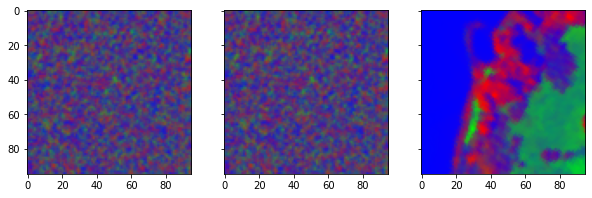

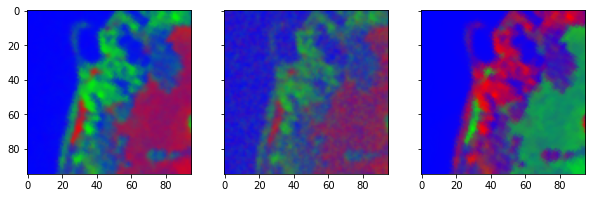

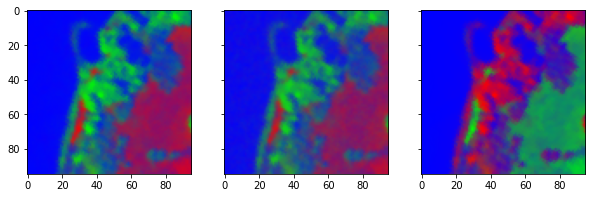

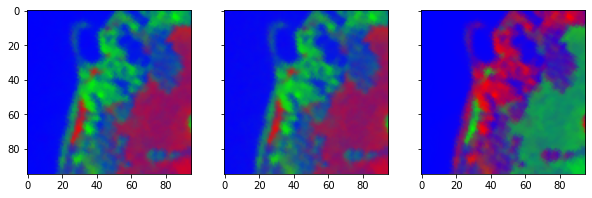

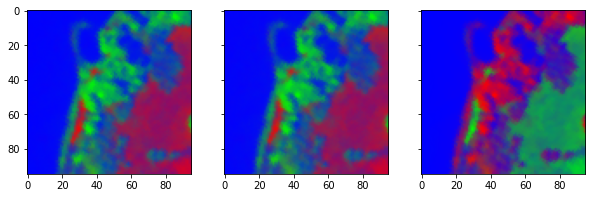

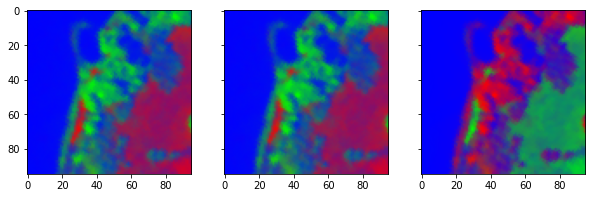

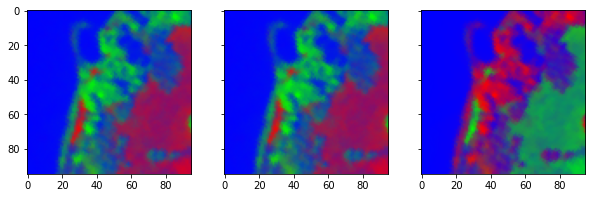

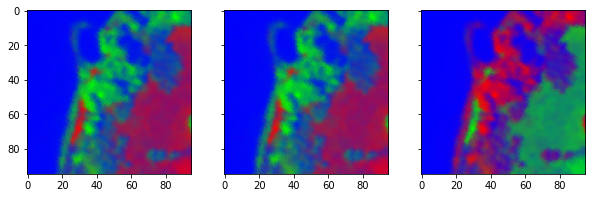

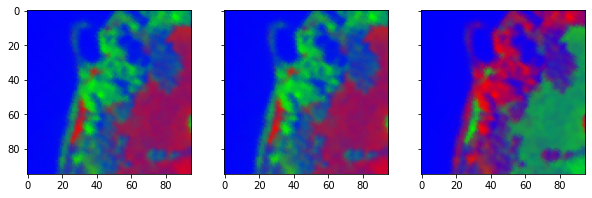

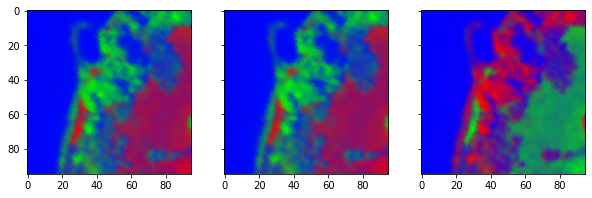

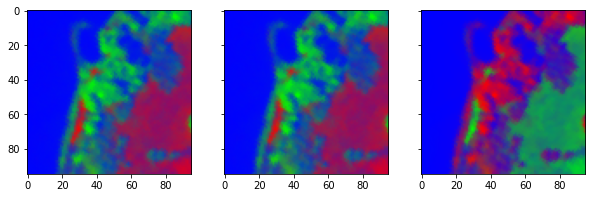

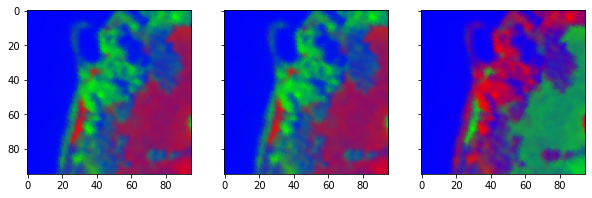

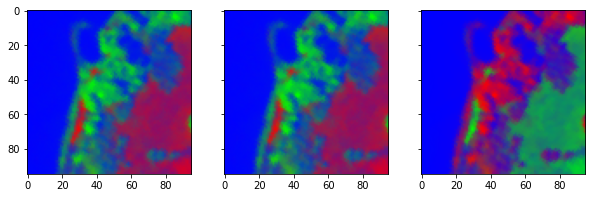

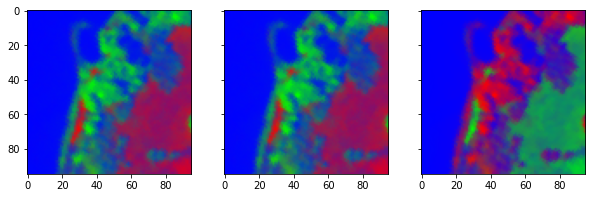

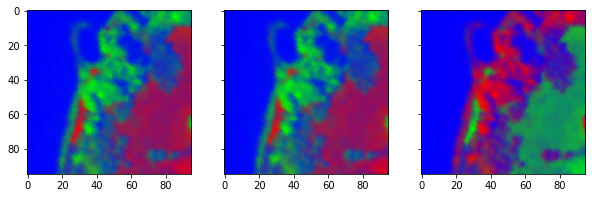

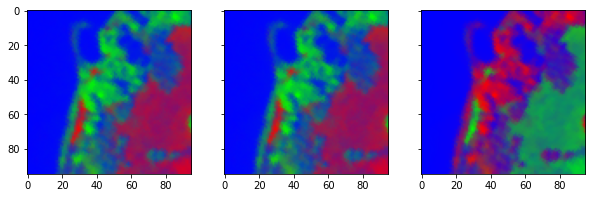

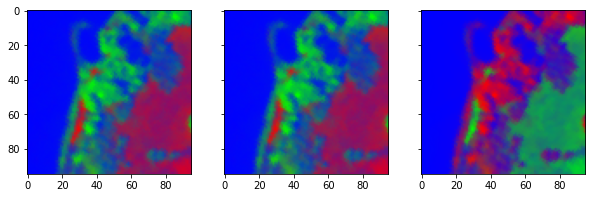

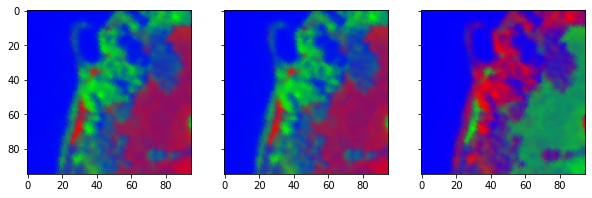

  0%|          | 0/4 [01:57<?, ?it/s]

KeyboardInterrupt: ignored

In [9]:
for fi in tqdm(range(tol1)):
    for fj in tqdm(range(tol2)):
            #%%
        #img_noisy_np = get_noisy_image(img_np_gt, 1/10)
        img_noisy_np = add_noise(img_np_gt, 1/npar[0,fi])#11.55 20 dB, 36.7 30 dB, 116.5 40 dB
        print(compare_snr(img_np_gt, img_noisy_np))
        img_resh=np.reshape(img_noisy_np,(p1,nr1*nc1))
        V, SS, U = scipy.linalg.svd(img_resh, full_matrices=False)
        PC=np.diag(SS)@U
        img_resh_DN=V[:,:rmax]@PC[:rmax,:]
        img_resh_np_clip=np.clip(img_resh_DN, 0, 1)
        II,III = Endmember_extract(img_resh_np_clip,rmax)
        E_np1=img_resh_np_clip[:,II]
        #asq=Endmember_reorder2(E_np,E_np1)
        #asq1=rmax-1-asq
        #E_np1=E_np1[:,asq]  
        #%% Set up Simulated 
        INPUT = 'noise' # 'meshgrid'
        pad = 'reflection'
        need_bias=True
        OPT_OVER = 'net' # 'net,input'
        
        # 
        reg_noise_std = 0.0# 1/100# 1./30. # set to 1./20. for sigma=50
        LR1 = 0.001
        
        OPTIMIZER1='adam' # 'RMSprop'#'adam' # 'LBFGS'
        show_every = 100
        exp_weight=0.99
        
        num_iter1 = 3000
        input_depth = rmax#img_noisy_np.shape[0]
        class CAE_AbEst(nn.Module):
            def __init__(self):
                super(CAE_AbEst, self).__init__()
                # encoding layers
                self.conv1 = nn.Sequential(
                     UnmixArch(
                            input_depth, rmax,
                            # num_channels_down = [8, 16, 32, 64, 128], 
                            # num_channels_up   = [8, 16, 32, 64, 128],
                            # num_channels_skip = [4, 4, 4, 4, 4], 
                            num_channels_down = [ 256],
                            num_channels_up =   [ 256],
                            num_channels_skip =    [ 4],  
                            filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
                            upsample_mode='bilinear', # downsample_mode='avg',
                            need1x1_up=True,
                            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
                )

            def forward(self, x):
                x = self.conv1(x)

                return x

        net1 = CAE_AbEst()
        net1.cuda()
        print(net1)

        # Compute number of parameters
        s  = sum([np.prod(list(p11.size())) for p11 in net1.parameters()]); 
        print ('Number of params: %d' % s)
        
        # Loss
        mse = torch.nn.MSELoss().type(dtype)
        img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
        # if fk==0:
        net_input1 = get_noise(input_depth, INPUT,
          (img_noisy_np.shape[1], img_noisy_np.shape[2])).type(dtype).detach()
        E_torch = np_to_torch(E_np1).type(dtype)
        #
        A_true_np_resh=A_true_np.reshape(A_true_np.shape[0],A_true_np.shape[1]*A_true_np.shape[2])
        #%%
        net_input_saved = net_input1.detach().clone()
        noise = net_input1.detach().clone()
        out_avg = None
        out_HR_avg= None
        last_net = None
        RMSE_LR_last = 0
        
        i = 0
        def closure1():
            
            global i, RMSE_LR, RMSE_LR_ave, RMSE_HR, out_LR_np, out_avg_np, out_LR\
                , out_avg,out_HR_np, out_HR_avg, out_HR_avg_np, RMSE_LR_last, last_net\
                    , net_input,RMSE_LR_avg,RMSE_HR_avg,RE_HR_avg, RE_HR, Eest\
                        , MAE_LR,MAE_LR_avg,MAE_HR,MAE_HR_avg
            
            if reg_noise_std > 0:
                net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
            out_LR = net1(net_input1)
            out_HR=torch.mm(E_torch.view(p1,rmax),out_LR.view(rmax,nr1*nc1))
            # Smoothing
            if out_avg is None:
                out_avg = out_LR.detach()
                out_HR_avg = out_HR.detach()
            else:
                out_avg = out_avg * exp_weight + out_LR.detach() * (1 - exp_weight)
                out_HR_avg = out_HR_avg * exp_weight + out_HR.detach() * (1 - exp_weight)
              
        #%%
            out_HR=out_HR.view((1,p1,nr1,nc1))
            total_loss = mse(img_noisy_torch, out_HR)
            total_loss.backward()
        
         
        
            out_LR_np = out_LR.detach().cpu().squeeze().numpy()
            out_avg_np = out_avg.detach().cpu().squeeze().numpy()
            out_HR_np = out_HR.detach().cpu().squeeze().numpy()
           # out_HR_avg=out_HR_avg.view((1,p1,nr1,nc1))
            out_HR_avg_np = out_HR_avg.detach().cpu().squeeze().numpy()
            RMSE_LR = 100*np.sqrt(compare_mse(A_true_np.astype(np.float32), np.clip(out_LR_np, 0, 1)))
            RMSE_LR_avg   = 100*np.sqrt(compare_mse(A_true_np.astype(np.float32), np.clip(out_avg_np, 0, 1)))
            RMSE_HR= 100*np.sqrt(compare_mse(img_np_gt.astype(np.float32), np.clip(out_HR_np, 0, 1)))
            RMSE_HR_avg= 100*np.sqrt(compare_mse(img_np_gt.astype(np.float32).reshape((p1,nr1*nc1)), np.clip(out_HR_avg_np, 0, 1)))
            MAE_LR= 100*np.mean(abs(A_true_np.astype(np.float32)- np.clip(out_LR_np, 0, 1)))
            MAE_HR= 100*np.mean(abs(img_np_gt.astype(np.float32)- np.clip(out_HR_np, 0, 1)))
            MAE_LR_avg= 100*np.mean(abs(A_true_np.astype(np.float32)- np.clip(out_avg_np, 0, 1)))
            MAE_HR_avg= 100*np.mean(abs(img_np_gt.astype(np.float32).reshape((p1,nr1*nc1))- np.clip(out_HR_avg_np, 0, 1)))
            
            
            RE_HR= 100*np.sqrt(compare_mse(img_noisy_np.astype(np.float32), np.clip(out_HR_np, 0, 1)))
            RE_HR_avg= 100*np.sqrt(compare_mse(img_noisy_np.astype(np.float32).reshape((p1,nr1*nc1)), np.clip(out_HR_avg_np, 0, 1)))

            # Note that we do not have GT for the "snail" example
            # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
            print ('Iteration %05d    Loss %f   RMSE_LR: %f   RMSE_LR_avg: %f RMSE_HR: %f  RMSE_HR_avg: %f' % (i, total_loss.item(), RMSE_LR, RMSE_LR_avg, RMSE_HR, RMSE_HR_avg), '\r', end='')
            if  PLOT and i % show_every == 0:
                out_LR_np = torch_to_np(out_LR)
                out_avg_np = torch_to_np(out_avg)

                out_LR_np = np.clip(out_LR_np, 0, 1)
                out_avg_np = np.clip(out_avg_np, 0, 1)
                
                f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,10))
                ax1.imshow(np.stack((out_LR_np[2,:,:],out_LR_np[1,:,:],out_LR_np[0,:,:]),2))
                ax2.imshow(np.stack((out_avg_np[2,:,:],out_avg_np[1,:,:],out_avg_np[0,:,:]),2))
                ax3.imshow(np.stack((A_true_np[2,:,:],A_true_np[1,:,:],A_true_np[0,:,:]),2))
                plt.show()
    
            i += 1
        
            return total_loss
        
        p11 = get_params(OPT_OVER, net1, net_input1)
        optimize(OPTIMIZER1, p11, closure1, LR1, num_iter1)